# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [2]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  0.591546  0.033827  0.0  0.067330  0.857357 -1.990037  0  1  -4.138879   
1  1.092994  0.689902  0.0  0.372155 -1.571268 -1.917071  1  2  -5.624793   
2  0.359290 -1.075900  0.0  0.011003 -1.100399 -0.758700  2  0  -0.153402   
3  0.193066  0.562765  0.0  0.277974 -0.297799  0.925022  2  1  17.004397   
4  1.163596  0.816869  0.0  0.554796 -0.417909  0.435380  3  2  22.618271   

            y  
0  -48.313541  
1  -89.225627  
2   -4.294392  
3  207.894700  
4  365.170583  
True causal estimate is 11.325763652920772


In [3]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


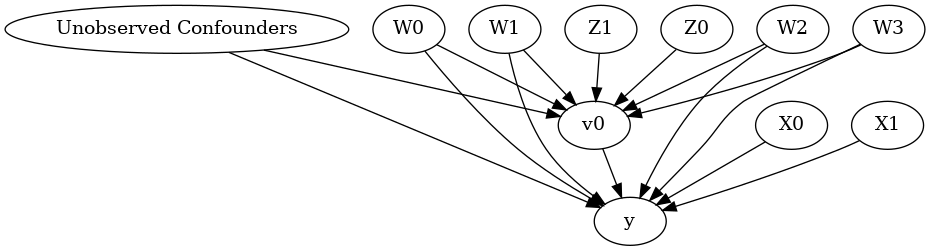

In [4]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [5]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
  d                                    
─────(Expectation(y|W3,X1,X0,W1,W2,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,X1,X0,W1,W2,W0,U) = P(y|v0,W3,X1,X0,W1,W2,W0)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
  d                                 
─────(Expectation(y|W3,X1,W1,W2,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,X1,W1,W2,W0,U) = P(y|v0,W3,X1,W1,W2,W0)

### Estimand : 3
Estimand name: backdoor3
Estimand expression:
  d                                 
─────(Expectation(y|W3,X0,W1,W2,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,X0,W1,W2,W0,U) = P(y|v0,W3,X0,W1,W2,W0)

### Estimand : 4
Estimand name: backdoor4
Estimand expression:
  d        

## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [6]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0+v0*X1+v0*X0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W3+X1+X0+W1+W2+W0+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 11.326105364617511
### Conditional Estimates
__categorical__X1              __categorical__X0
(-4.1450000000000005, -0.609]  (-3.774, -0.582]      3.841777
                               (-0.582, 0.014]       7.011565
                               (0.014, 0.507]        8.832859
                               (0.507, 1.092]       10.668375
                               (1.092, 4.098]       13.750364
(-0.609, -0.0247]              (-3.774, -0.582]      5.373921
                               (-0.582, 0.014]       8.443226
                               (0.014, 0.507]       10.366727
                               (0.507, 1.092]       12.249162
                               (1.092, 4.098]       15.339288
(-0.0247, 0.481]               (-3.774, -0.582]      6.461544
                               (-0.582, 

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DMLCateEstimator". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 16.187161835350988
Effect estimates: [15.29950539 15.80273836 11.66750645 ... 11.52959683 17.43508852
 16.71608706]



In [8]:
print("True causal estimate is", data["ate"])

True causal estimate is 11.325763652920772


In [9]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
Target units: 

## Estimate
Mean value: 11.32489891907349
Effect estimates: [12.18174823 15.23804633  9.26635332 ...  6.09804327 17.32202569
 16.69765206]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 11.321229874780466
Effect estimates: [12.18029748 15.2648268   9.23076961 ...  6.04281383 17.37481584
 16.7150627 ]
95.0% confidence interval: (array([11.91870657, 14.86115283,  9.01918379, ...,  5.91264752,
       16.8406081 , 16.18462375]), array([12.09535099, 15.09815215,  9.30291818, ...,  6.22995537,
       17.18768653, 16.61109846]))



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


### Can provide a new inputs as target units and estimate CATE on them.

In [11]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0


[13.84572746 14.48240807 11.84585949 10.1652605  11.61307161 13.37544329
 14.28646452 14.03595988 11.33292231 12.8667995 ]


### Can also retrieve the raw EconML estimator object for any further operations

In [12]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [13]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


            X0        X1   Z0        Z1        W0        W1        W2  \
0    -1.098006 -2.019245  0.0  0.308500  0.015803 -0.649274 -1.228311   
1     0.677735 -1.124187  1.0  0.242680 -1.282971  0.384336 -0.895845   
2    -0.978097 -0.273694  1.0  0.634024 -0.632586  1.766797  0.888634   
3     0.344985 -0.006678  1.0  0.721471 -0.074841  1.701512  1.376021   
4    -0.599348 -1.819906  1.0  0.415879 -2.281334  1.018269 -1.072073   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.963397 -1.108432  0.0  0.569886 -0.323109 -0.756179  0.749255   
9996  1.568798  0.542782  1.0  0.086985 -1.332216  1.670493 -0.590471   
9997 -0.755060  0.534957  0.0  0.281114  0.562832  1.158688  0.243083   
9998 -1.066606 -1.538280  1.0  0.229653  0.567940  2.079005  1.614888   
9999  1.447108  0.038672  0.0  0.415152 -0.918827  1.190736 -0.546687   

            W3  v0  y  
0     0.082440   1  0  
1     1.068660   1  1  
2    -0.815980   1  1  
3     0.614936   1  1  
4  

#### Using DRLearner estimator

In [14]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 0.5080204478768279
Effect estimates: [0.35334523 0.47914002 0.49842889 ... 0.57066295 0.3932721  0.59646643]

True causal estimate is 0.3635


### Instrumental Variable Method

In [15]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model._instruments)+len(model._effect_modifiers)
dims_tx = len(model._treatment)+len(model._effect_modifiers)
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIVEstimator",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

Using TensorFlow backend.
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0


Epoch 1/25
10000/10000 [==============================] - 2s 226us/step - loss: 6.1088
Epoch 2/25
10000/10000 [==============================] - 2s 170us/step - loss: 3.2974
Epoch 3/25
10000/10000 [==============================] - 2s 186us/step - loss: 3.0126
Epoch 4/25
10000/10000 [==============================] - 1s 145us/step - loss: 2.8919
Epoch 5/25
10000/10000 [==============================] - 1s 145us/step - loss: 2.8281
Epoch 6/25
10000/10000 [==============================] - 1s 112us/step - loss: 2.7813
Epoch 7/25
10000/10000 [==============================] - 2s 197us/step - loss: 2.7695
Epoch 8/25
10000/10000 [==============================] - 2s 194us/step - loss: 2.7502
Epoch 9/25
10000/10000 [==============================] - 2s 234us/step - loss: 2.7462
Epoch 10/25
10000/10000 [==============================] - 2s 248us/step - loss: 2.7431
Epoch 11/25
10000/10000 [==============================] - 2s 196us/step - loss: 2.7462
Epoch 12/25
10000/10000 [================

### Metalearners

In [16]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


            X0        X1        X2        X3        X4   Z0        Z1  \
0     1.586050 -1.216074 -0.821309  0.970771 -0.343337  1.0  0.552651   
1     0.625370  0.181516  1.606094  1.336593 -0.341328  0.0  0.287180   
2     0.687855 -1.772641  0.597583  0.502648  0.376580  1.0  0.327799   
3     0.531408  0.961152 -1.218962  1.187657  2.684778  0.0  0.577067   
4     1.469161  0.090709 -0.233138 -0.105213  1.320928  0.0  0.598978   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.276973  0.776489  0.271114  0.888483  0.714043  0.0  0.832272   
9996 -0.517284 -0.884235 -1.049950 -0.741389  1.231788  0.0  0.335755   
9997  2.095355  0.608958 -0.776241  1.290803 -0.587471  0.0  0.776284   
9998  0.235670  0.512478  0.602416  1.249560  0.449082  0.0  0.197897   
9999  1.024872  1.171202  1.047577  0.559394  2.549732  0.0  0.990966   

            W0        W1        W2        W3        W4  v0          y  
0    -1.461819 -0.041981 -1.080606 -2.513316  0.339

In [17]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+X1+X3+X4+X0+X2+W3+W4+W1+W2+W0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+X1+X3+X4+X0+X2+W3+W4+W1+W2+W0
Target units: ate

## Estimate
Mean value: 18.997205810922118
Effect estimates: [16.14363526 21.49767171 14.85593094 ... 20.08789603 26.5516269
 40.78624431]

True causal estimate is 15.50782217992119


## Refuting the estimate

### Random 

In [18]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0


Refute: Add a Random Common Cause
Estimated effect:12.784991662072116
New effect:12.8063369711323



### Adding an unobserved common cause variable

In [19]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0


Refute: Add an Unobserved Common Cause
Estimated effect:12.784991662072116
New effect:12.812523087265514



### Replacing treatment with a random (placebo) variable

In [20]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 10 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_es

Refute: Use a Placebo Treatment
Estimated effect:12.784991662072116
New effect:-0.013587007610476412
p value:0.2629036449396689



### Removing a random subset of the data

In [22]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.8 simulated datasets of size 8000.0 each
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+X1+X0+W1+W2+W0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO

Refute: Use a subset of data
Estimated effect:12.784991662072116
New effect:12.761438695216484
p value:0.3212010747552727



More refutation methods to come, especially specific to the CATE estimators.